# TensorFlow MNIST

Based on the TensorFlow tutorial at http://tensorflow.org/tutorials/mnist/pros/index.md

In [6]:
import numpy as np
import tensorflow as tf
import idx2numpy

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(4, 4)

## Read In Data

In [7]:
prefix = "/Users/jeffreyschecter/Desktop/mnist/"
train_im = idx2numpy.convert_from_file(prefix + "train-images-idx3-ubyte")
test_im = idx2numpy.convert_from_file(prefix + "t10k-images-idx3-ubyte")

In [8]:
train_labels = idx2numpy.convert_from_file(prefix + "train-labels-idx1-ubyte")
test_labels = idx2numpy.convert_from_file(prefix + "t10k-labels-idx1-ubyte")

## Throw a random forest at it

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(train_im.reshape(60000, 28 * 28), train_labels)
model_labels = clf.predict(test_im.reshape(10000, 28 * 28))
(model_labels == test_labels).mean()

0.97140000000000004

## Simple softmax regression w/ TensorFlow

In [10]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


In [11]:
x = tf.placeholder(tf.float32, shape=[None, 28 * 28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([28 * 28, 10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.initialize_all_variables())

In [12]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(xent)

In [13]:
train_labels_one_hot = np.zeros((60000, 10))
train_labels_one_hot[np.arange(60000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

In [14]:
batch_size = 1000
epochs = 10
for ep in xrange(epochs):
    print "Starting training epoch {ep}".format(ep=ep)
    for i in xrange(train_im.shape[0] / batch_size):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset].reshape(batch_size, 28 * 28),
            y_: train_labels_one_hot[start_offset:stop_offset]
        })
    accuracy_expr = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32))
    accuracy = accuracy_expr.eval(feed_dict={
        x: test_im.reshape(10000, 28 * 28),
        y_: test_labels_one_hot})
    print accuracy
    

Starting training epoch 0
0.893
Starting training epoch 1
0.9041
Starting training epoch 2
0.9092
Starting training epoch 3
0.9115
Starting training epoch 4
0.9139
Starting training epoch 5
0.9156
Starting training epoch 6
0.9165
Starting training epoch 7
0.9177
Starting training epoch 8
0.9186
Starting training epoch 9
0.9195


## Simple ConvNet w/ TensorFlow

In [15]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [16]:
def weight_variable(shape):
    initial = tf.random_uniform(shape, minval=-0.01, maxval=0.01)
    return tf.Variable(initial, name="weights")

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name="conv")

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME', name="max_pool")

def elu(x):
    pos = tf.cast(tf.greater_equal(x, 0), tf.float32)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

#### Inputs

In [17]:
x = tf.placeholder(tf.float32, [None, 28, 28])
y_ = tf.placeholder(tf.float32, [None, 10])

#### Internal Structure and Outputs

In [18]:
# Compare elu vs. tf.nnet.relu
nonlin = elu

with tf.name_scope("conv1") as scope:
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = nonlin(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("conv2") as scope:
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = nonlin(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("dense") as scope:
    W_dense = weight_variable([7 * 7 * 64, 1024])
    b_dense = bias_variable([1024])
    h_dense = nonlin(tf.matmul(tf.reshape(h_pool2, [-1, 7 * 7 * 64]), W_dense) + b_dense)

with tf.name_scope("dropout") as scope:
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    h_dropout = tf.nn.dropout(h_dense, keep_prob)

with tf.name_scope("softmax_output") as scope:
    W_out = weight_variable([1024, 10])
    b_out = bias_variable([10])
    y = tf.nn.softmax(tf.matmul(h_dropout, W_out) + b_out)

#### Training, Evaluation, and Initilization

In [19]:
xent = -tf.reduce_mean(y_ * tf.log(y))
learn_rate = tf.placeholder(tf.float32, [])
train_step = tf.train.AdamOptimizer(learn_rate).minimize(xent)
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.initialize_all_variables())

#### Main Loop

In [20]:
num_epochs = 1
batch_size = 200
dropout_keep_rate = 0.5
base_learn_rate = 0.0001
test_every_n_batches = 20
decay_factor = 5

batches_per_epoch = train_im.shape[0] / batch_size
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        this_learn_rate = base_learn_rate / (decay_factor ** (ep + (i / float(batches_per_epoch))))
        print "epoch {ep}, batch {ba} / {bpe}: learn rate = {lr}".format(
            ep=ep, ba=i, lr=this_learn_rate, bpe=batches_per_epoch)
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset],
            y_: train_labels_one_hot[start_offset:stop_offset],
            keep_prob: dropout_keep_rate,
            learn_rate: this_learn_rate})
        if i % test_every_n_batches == 0:
            ac = accuracy.eval(feed_dict={
                x: test_im[:100],
                y_: test_labels_one_hot[:100],
                keep_prob: 1.0})
            print "\nFinished epoch {ep}, batch {ba}: accuracy = {ac:.2f}\n".format(ep=ep, ba=i, ac=ac)
    ac = accuracy.eval(feed_dict={
        x: test_im,
        y_: test_labels_one_hot,
        keep_prob: 1.0})
    print "\nEND OF EPOCH {ep}: accuracy = {ac:.4f}\n".format(ep=ep, ac=ac)

epoch 0, batch 0 / 300: learn rate = 0.0001

Finished epoch 0, batch 0: accuracy = 0.37

epoch 0, batch 1 / 300: learn rate = 9.94649571761e-05
epoch 0, batch 2 / 300: learn rate = 9.89327770605e-05
epoch 0, batch 3 / 300: learn rate = 9.84034443363e-05
epoch 0, batch 4 / 300: learn rate = 9.7876943769e-05
epoch 0, batch 5 / 300: learn rate = 9.73532602051e-05
epoch 0, batch 6 / 300: learn rate = 9.68323785726e-05
epoch 0, batch 7 / 300: learn rate = 9.63142838798e-05
epoch 0, batch 8 / 300: learn rate = 9.57989612155e-05
epoch 0, batch 9 / 300: learn rate = 9.52863957482e-05
epoch 0, batch 10 / 300: learn rate = 9.47765727256e-05
epoch 0, batch 11 / 300: learn rate = 9.42694774745e-05
epoch 0, batch 12 / 300: learn rate = 9.37650954002e-05
epoch 0, batch 13 / 300: learn rate = 9.3263411986e-05
epoch 0, batch 14 / 300: learn rate = 9.27644127928e-05
epoch 0, batch 15 / 300: learn rate = 9.22680834591e-05
epoch 0, batch 16 / 300: learn rate = 9.17744096998e-05
epoch 0, batch 17 / 300: l

### Build a random forest based on hidden layer activations

In [21]:
import time
hidden_list = []
for i in xrange(60):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: train_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 1.82 seconds
Batch 1 in 1.80 seconds
Batch 2 in 2.56 seconds
Batch 3 in 1.93 seconds
Batch 4 in 1.79 seconds
Batch 5 in 1.76 seconds
Batch 6 in 1.76 seconds
Batch 7 in 1.73 seconds
Batch 8 in 1.74 seconds
Batch 9 in 1.74 seconds
Batch 10 in 1.76 seconds
Batch 11 in 1.78 seconds
Batch 12 in 1.75 seconds
Batch 13 in 1.74 seconds
Batch 14 in 1.78 seconds
Batch 15 in 1.78 seconds
Batch 16 in 1.77 seconds
Batch 17 in 1.75 seconds
Batch 18 in 1.76 seconds
Batch 19 in 1.75 seconds
Batch 20 in 1.77 seconds
Batch 21 in 1.77 seconds
Batch 22 in 1.75 seconds
Batch 23 in 1.76 seconds
Batch 24 in 1.77 seconds
Batch 25 in 1.96 seconds
Batch 26 in 2.26 seconds
Batch 27 in 2.02 seconds
Batch 28 in 1.77 seconds
Batch 29 in 2.09 seconds
Batch 30 in 1.77 seconds
Batch 31 in 1.80 seconds
Batch 32 in 1.81 seconds
Batch 33 in 2.17 seconds
Batch 34 in 2.16 seconds
Batch 35 in 1.86 seconds
Batch 36 in 1.81 seconds
Batch 37 in 1.82 seconds
Batch 38 in 1.81 seconds
Batch 39 in 2.25 seconds
Batch 40 i

In [22]:
hidden_train = np.array(hidden_list).reshape(60000, 1024)

In [23]:
hidden_list = []
for i in xrange(10):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: test_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 2.14 seconds
Batch 1 in 2.08 seconds
Batch 2 in 1.88 seconds
Batch 3 in 2.15 seconds
Batch 4 in 2.16 seconds
Batch 5 in 1.83 seconds
Batch 6 in 1.83 seconds
Batch 7 in 1.80 seconds
Batch 8 in 1.78 seconds
Batch 9 in 1.86 seconds


In [24]:
hidden_test = np.array(hidden_list).reshape(10000, 1024)

In [25]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(hidden_train, train_labels)
model_labels = clf.predict(hidden_test)
(model_labels == test_labels).mean()

0.97699999999999998

In [41]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

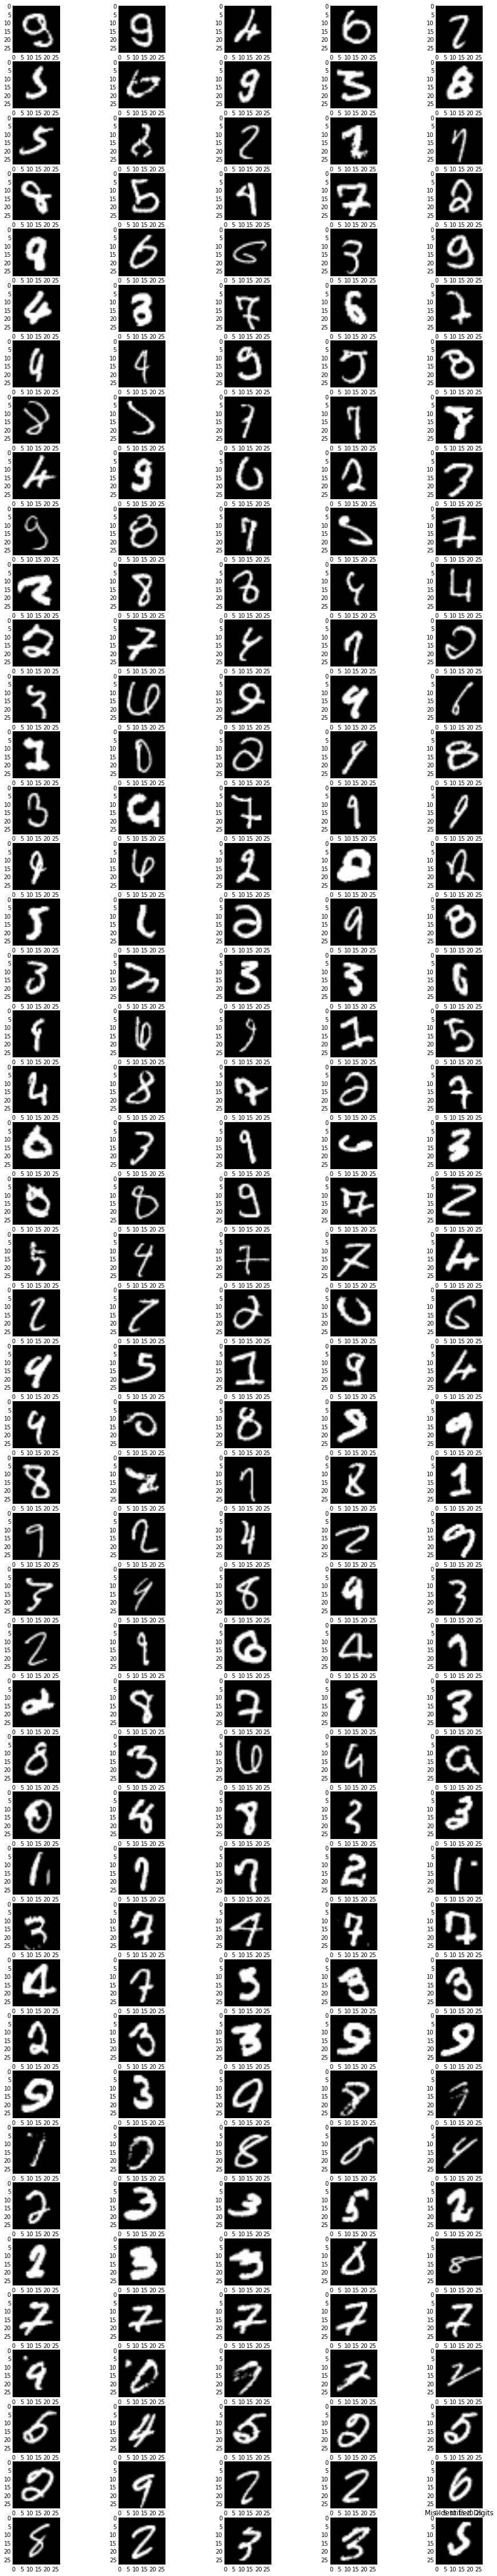

In [61]:
from matplotlib import cm

figsize(16, 80)
_, axes = plt.subplots(46, 5)
axes = axes.reshape(230)

for x in xrange(len(misses)):
    im = misses[x]
    test_label = miss_test_labels[x]
    guess_label = miss_guess_labels[x]
    ax = axes[x]
    ax.imshow(im, cmap=cm.gray)
plt.show()

In [108]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

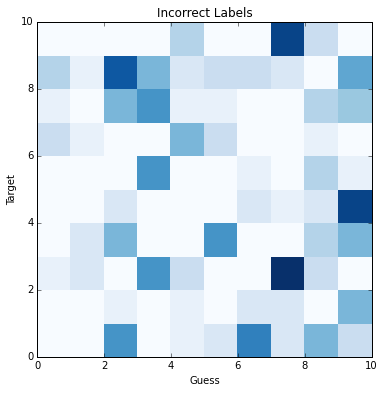

In [116]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Targ")
plt.ylabel("Target")
plt.title("Incorrect Labels")
plt.show()